In [1]:
#---------------------------------------------------------------------------------
#                                 _             _      
#                                | |_  ___ _ __(_)__ _ 
#                                | ' \/ -_) '_ \ / _` |
#                                |_||_\___| .__/_\__,_|
#                                         |_|          
#
#---------------------------------------------------------------------------------
#
# Company: HEPIA // HES-SO
# Engineer: Hugo Varenne <hugo.varenne@master.hes-so.ch>
# 
# Project Name: Unleashing the Full Potential of 
#               High-Performance Cherenkov Telescopes
#               with Fully-Digital Solid-State Sensors Camera
#
# File: 5.0_Custom_Model_Usage.ipynb
# Description: Notebook for creating models using CTLearn
#
# Last update: 2025-10-02
#
#--------------------------------------------------------------------------------

### Imports

In [2]:
import sys
import os
import importlib
import hdf5plugin, h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import importlib
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from traitlets.config import Config
import yaml
from scipy.stats import norm
import operator
from tabulate import tabulate
import json
from IPython.display import display, HTML
# Custom tools
tools_path = os.path.join("../tools")
if tools_path not in sys.path:
    sys.path.append(tools_path)

In [3]:
# Set paths shortcuts (configurable in a yaml file)
import tools.CTLearnMgrConfig as CTLearnMgrConfig
importlib.reload(CTLearnMgrConfig)

ctlearn_mgr_config = CTLearnMgrConfig.CTLearnMgrConfig()
ctlearn_mgr_config.load_config('../config/ctlearnmgr_config.yml')

### Variables

In [4]:
# Type of task ["type", "energy", "direction"] or ["all"] if multiple graphics needs to be used
task = "type"


# Provide a specific model to compare only version of the model (None for all models and versions)
specific_model = None

# Specify if we want to compare only one version of each models
only_one_version = True

if task == "all":
    path_energy_models = os.path.join(ctlearn_mgr_config.workspace_path, "models", "energy")
    path_type_models = os.path.join(ctlearn_mgr_config.workspace_path, "models", "type")
else:
    path_models = os.path.join(ctlearn_mgr_config.workspace_path, "models", f"{task}")

### Training comparison

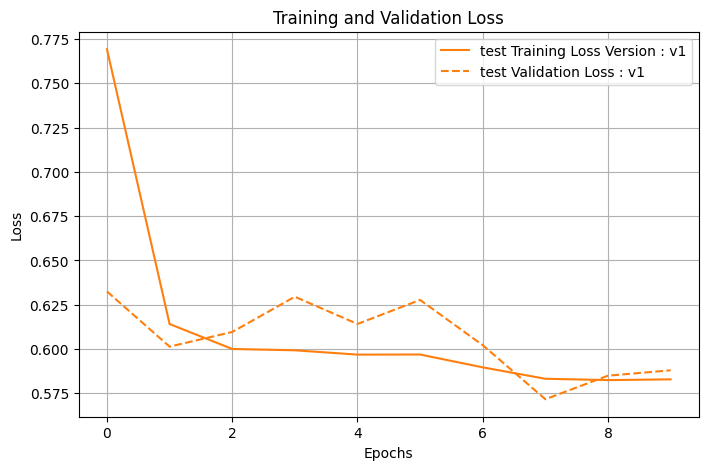

In [13]:
if task != "all":
    plt.figure(figsize=(8,5))
    colors = plt.cm.tab10.colors
    count = 1
    # Show training loss for each model and version
    for model in os.listdir(path_models):
        # If parameter defined, only one version per model shown
        versions = sorted(os.listdir(os.path.join(path_models, model)))
        if only_one_version and len(versions) != 1:
            versions = [versions[-1]]
        for version in versions :
            # Extract results 
            training_results = os.path.join(path_models, model, version, "training_log.csv")
            loss = pd.read_csv(training_results)
            # Get color for matching line
            color = colors[count % len(colors)]
            
            # Build line for graph
            if specific_model:
                if model == specific_model:
                    print("test")
                    plt.plot(loss["epoch"], loss["loss"], color=color, label=f"{model} Training Loss Version : {version}")
                    plt.plot(loss["epoch"], loss["val_loss"], color=color, linestyle="--", label=f"{model} Validation Loss : {version}")
            else:
                plt.plot(loss["epoch"], loss["loss"], color=color, label=f"{model} Training Loss Version : {version}")
                plt.plot(loss["epoch"], loss["val_loss"], color=color, linestyle="--", label=f"{model} Validation Loss : {version}")
            
            # Counter for colors 
            count += 1

    # Show graphic
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

### Evaluation of "type" models

In [14]:
if task == "type": 
    plt.figure(figsize=(6,6))
    mapping = {0: 1, 101: 0}
    
    # Go through each model
    for model in os.listdir(path_models):
        # If parameter defined, only one version per model shown
        versions = sorted(os.listdir(os.path.join(path_models, model)))
        if only_one_version:
            versions = [versions[-1]]
        for version in versions :  
            
            # Predictions files
            prediction_directory = os.path.join(model_path, version, "predict")
            
            # Prepare DataFrame and mapping for classes
            global_predictions_df = pd.DataFrame()
                       
            # Process prediction elements
            for file in os.listdir(prediction_directory):
                filename = os.path.join(prediction_directory, file)
                if filename.endswith(".h5"):
                    with h5py.File(filename, 'r') as data:
                        # Get DL2 predictions
                        if 'dl2/event/subarray/classification/CTLearn' in data:
                            # Predictions
                            pred_ds = data['dl2/event/subarray/classification/CTLearn']['event_id', 'CTLearn_prediction', 'CTLearn_is_valid']
                            pred_ds = pd.DataFrame(pred_ds)
                            
                            # Take only valid events
                            pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]
                            
                            # Ground truth
                            ground_truth = data["simulation/event/subarray/shower"][:]
                            ground_truth_df = pd.DataFrame(ground_truth, columns=["event_id", "true_shower_primary_id"])
    
                            # Combine ground truth with prediction
                            combined_df = pd.merge(pred_ds, ground_truth_df, on="event_id", how="inner")
                            combined_df["particle_id"] = combined_df["true_shower_primary_id"].map(mapping)
    
                            # Merge with others result files
                            global_predictions_df = pd.concat([global_predictions_df, combined_df], ignore_index=True)

            # Calculate ROC and AUC
            fpr_gamma, tpr_gamma, thresholds_gamma = metrics.roc_curve(global_predictions_df["particle_id"], global_predictions_df['CTLearn_prediction'], pos_label=1)
            auc_gamma = metrics.auc(fpr_gamma, tpr_gamma)

            # Calculate ROC
            plt.plot(fpr_gamma, tpr_gamma, label=f"Gamma vs Proton (AUC={auc_gamma:.3f}) Model : {model}, Version : {version}")

    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("CTLearn ROC Curve: Gamma vs Proton")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

### Evaluate model performances

In [15]:
METRICS = {
    "num_params": False,
    "layers": False,
    "training_ms": False,
    "inference_ms": False,
    "estimated_flops": False,
}
all_metrics = []

# Get the best metric for each models
for model in os.listdir(path_models):
        # If parameter defined, only one version per model shown
        versions = sorted(os.listdir(os.path.join(path_models, model)))
        if only_one_version:
            versions = [versions[-1]]
        for version in versions :  
            # Metric files
            metrics_file = os.path.join(path_models, model, version, "metrics.json")
            if os.path.exists(metrics_file):
                with open(metrics_file, "r") as file:
                    
                    data = json.load(file)
                    data["model"] = f"{model} - {version}"
                    all_metrics.append(data)
                    
# Convert to DataFrame
df = pd.DataFrame(all_metrics)

# Rank each metric
for metric, higher_is_better in METRICS.items():
    if metric in df.columns:
        df[f"{metric}_rank"] = (
            df[metric].rank(ascending=not higher_is_better, method="min").astype(int)
        )

# Compute average ranking
rank_cols = [col for col in df.columns if col.endswith("_rank")]
df["avg_rank"] = df[rank_cols].mean(axis=1)
df = df.sort_values("avg_rank")

# Format visually (tabulate)
table = tabulate(
    df[["model"] + list(METRICS.keys()) + rank_cols + ["avg_rank"]],
    headers="keys",
    tablefmt="html",
    floatfmt=".3f"
)

print("\n🏆 Model Ranking by Metrics\n")
display(HTML(f"<div style='overflow-x:auto; width:100%'>{table}</div>"))


🏆 Model Ranking by Metrics



,model,num_params,layers,training_ms,inference_ms,estimated_flops,num_params_rank,layers_rank,training_ms_rank,inference_ms_rank,estimated_flops_rank,avg_rank
0,test - v1,6013985,63,1884895.647,91114.768,0,1,1,1,1,1,1.000


### Evaluation of "energy" models

In [16]:
# Evaluate results for energy regression
if task == "energy":
    mapping_name = {0: "Gamma", 101: "Proton"}
    # Go through each model
    for model in os.listdir(path_models):
        # If parameter defined, only one version per model shown
        versions = sorted(os.listdir(os.path.join(path_models, model)))
        if only_one_version:
            versions = [versions[-1]]
        for version in versions :  
            # Predictions files
            prediction_directory = os.path.join(path_models, model, version, "predict")
            
            # Prepare DataFrame and mapping for classes
            global_predictions_df = pd.DataFrame()
    
            for file in os.listdir(prediction_directory):
                    filename = os.path.join(prediction_directory, file)
                    if filename.endswith(".h5"):
                        with h5py.File(filename, 'r') as data:
                            # Get DL2 predictions
                            if 'dl2/event/subarray/energy/CTLearn' in data:
                                # Predictions
                                pred_ds = data['dl2/event/subarray/energy/CTLearn']['event_id', 'CTLearn_energy', 'CTLearn_is_valid', 'CTLearn_energy_uncert']
                                pred_ds = pd.DataFrame(pred_ds)
                                pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]
                                
                                # Ground Truth
                                ground_truth = data["simulation/event/subarray/shower"][:]
                                ground_truth_df = pd.DataFrame(ground_truth, columns=["event_id", "true_energy", "true_shower_primary_id"])
                                
                                # Combine ground truth with prediction
                                combined_df = pd.merge(pred_ds, ground_truth_df, on="event_id", how="inner")
                                combined_df["particle_name"] = combined_df["true_shower_primary_id"].map(mapping_name)
                                
                                # Merge with others result files
                                global_predictions_df = pd.concat([global_predictions_df, combined_df], ignore_index=True)
                            
            mse = mean_squared_error(global_predictions_df["CTLearn_energy"], global_predictions_df["true_energy"])
            r2 = r2_score(global_predictions_df["CTLearn_energy"], global_predictions_df["true_energy"])
            print(f"%%%% - Precision of {model} - {version} for Energy regression - %%%%%")
            print(f"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
            print(f"MSE : {mse} --- rMSE {np.sqrt(mse)} --- r2 : {r2}")

%%%% - Precision of test - v1 for Energy regression - %%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
MSE : 69876.43249561058 --- rMSE 264.3415073264329 --- r2 : -0.1669733163209015


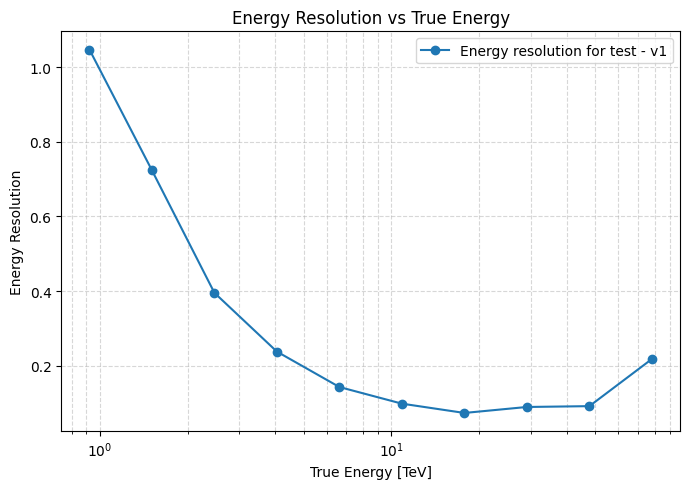

In [17]:
if task == "energy":
    plt.figure(figsize=(7, 5))
    mapping_name = {0: "Gamma", 101: "Proton"}

    # Go through each model
    for model in os.listdir(path_models):
        # If parameter defined, only one version per model shown
        versions = sorted(os.listdir(os.path.join(path_models, model)))
        if only_one_version:
            versions = [versions[-1]]
        for version in versions :  
            # Predictions files
            prediction_directory = os.path.join(path_models, model, version, "predict")
            
            # Prepare DataFrame and mapping for classes
            global_predictions_df = pd.DataFrame()
    
            for file in os.listdir(prediction_directory):
                    filename = os.path.join(prediction_directory, file)
                    if filename.endswith(".h5"):
                        with h5py.File(filename, 'r') as data:
                            # Get DL2 predictions
                            if 'dl2/event/subarray/energy/CTLearn' in data:
                                # Predictions
                                pred_ds = data['dl2/event/subarray/energy/CTLearn']['event_id', 'CTLearn_energy', 'CTLearn_is_valid', 'CTLearn_energy_uncert']
                                pred_ds = pd.DataFrame(pred_ds)
                                pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]
                                
                                # Ground Truth
                                ground_truth = data["simulation/event/subarray/shower"][:]
                                ground_truth_df = pd.DataFrame(ground_truth, columns=["event_id", "true_energy", "true_shower_primary_id"])
                                
                                # Combine ground truth with prediction
                                combined_df = pd.merge(pred_ds, ground_truth_df, on="event_id", how="inner")
                                combined_df["particle_name"] = combined_df["true_shower_primary_id"].map(mapping_name)
                                
                                # Merge with others result files
                                global_predictions_df = pd.concat([global_predictions_df, combined_df], ignore_index=True)

            # Extract only wanted energies
            energy_pred = global_predictions_df["CTLearn_energy"]
            energy_true = global_predictions_df["true_energy"]

            # Build bins (0.1–100 TeV)
            bins = np.logspace(-1, 2, 15)

            # Calculate relative error
            rel_err = (energy_pred - energy_true) / energy_true

            # Assign event to bins
            indices = np.digitize(energy_true, bins)
            results = []

            # For each bin
            for i in range(1, len(bins)):
                # Check if enough data in a bin
                mask = indices == i
                if np.sum(mask) < 20:
                    continue

                # Calculate mean bias (μ) and sigma gauss (σ) / Mean bias is the systematic offset between true and reconstructed energies / Sigma gauss is the standard deviation of relative error distribution
                err_bin = rel_err[mask]
                mu, sigma = norm.fit(err_bin)

                # Representative energy
                represent_energy = np.sqrt(bins[i-1] * bins[i])
                
                results.append({
                    "represent_energy": represent_energy,
                    "mean_bias": mu,
                    "sigma": sigma
                })

            line_data = pd.DataFrame(results)
            # Add line to graph
            if specific_model :
                if model == specific_model:            
                    plt.plot(line_data["represent_energy"], line_data["sigma"], "o-", label=f"Energy resolution for {model} - {version}")
            else:
                if model != "simple":
                    plt.plot(line_data["represent_energy"], line_data["sigma"], "o-", label=f"Energy resolution for {model} - {version}")
            
    plt.xscale("log")
    plt.xlabel("True Energy [TeV]")
    plt.ylabel("Energy Resolution")
    plt.title("Energy Resolution vs True Energy")
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()          

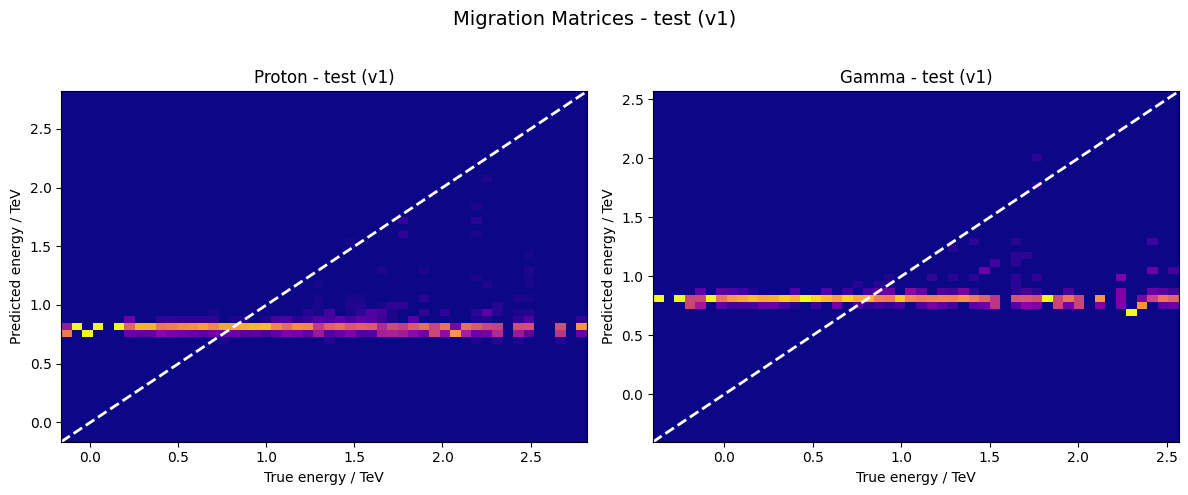

In [18]:
# Evaluate results for energy regression
if task == "energy":
    mapping_name = {0: "Gamma", 101: "Proton"}
    # Go through each model
    for model in os.listdir(path_models):
        # If parameter defined, only one version per model shown
        versions = sorted(os.listdir(os.path.join(path_models, model)))
        if only_one_version:
            versions = [versions[-1]]
        for version in versions :  
            # Predictions files
            prediction_directory = os.path.join(path_models, model, version, "predict")
            
            # Prepare DataFrame and mapping for classes
            global_predictions_df = pd.DataFrame()
    
            for file in os.listdir(prediction_directory):
                    filename = os.path.join(prediction_directory, file)
                    if filename.endswith(".h5"):
                        with h5py.File(filename, 'r') as data:
                            # Get DL2 predictions
                            if 'dl2/event/subarray/energy/CTLearn' in data:
                                # Predictions
                                pred_ds = data['dl2/event/subarray/energy/CTLearn']['event_id', 'CTLearn_energy', 'CTLearn_is_valid', 'CTLearn_energy_uncert']
                                pred_ds = pd.DataFrame(pred_ds)
                                pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]
                                
                                # Ground Truth
                                ground_truth = data["simulation/event/subarray/shower"][:]
                                ground_truth_df = pd.DataFrame(ground_truth, columns=["event_id", "true_energy", "true_shower_primary_id"])
                                
                                # Combine ground truth with prediction
                                combined_df = pd.merge(pred_ds, ground_truth_df, on="event_id", how="inner")
                                combined_df["particle_name"] = combined_df["true_shower_primary_id"].map(mapping_name)
                                
                                # Merge with others result files
                                global_predictions_df = pd.concat([global_predictions_df, combined_df], ignore_index=True)
                            

            fig, axes = plt.subplots(1, len(global_predictions_df["particle_name"].unique()), figsize=(12, 5))
            for i, particle in enumerate(global_predictions_df["particle_name"].unique()):

                # Extract only wanted energies
                particle_df = global_predictions_df[global_predictions_df["particle_name"] == particle]
                
                # Extract only wanted energies
                energy_pred = particle_df["CTLearn_energy"]
                energy_true = particle_df["true_energy"]
                log_pred = np.log10(energy_pred)
                log_true = np.log10(energy_true)
    
                
                # Prepare matrix
                H, xedges, yedges = np.histogram2d(
                    log_true, log_pred,
                    bins=50,
                    range=[[log_true.min(), log_true.max()],
                           [log_true.min(), log_true.max()]]
                )
                H = H / (H.sum(axis=1, keepdims=True) + 1e-8)

                # Show graphic
                im = axes[i].imshow(
                    H.T, origin="lower",
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    aspect="auto", cmap="plasma"
                )
                axes[i].plot([xedges[0], xedges[-1]], [xedges[0], xedges[-1]], "w--", lw=2)
                axes[i].set_xlabel("True energy / TeV")
                axes[i].set_ylabel("Predicted energy / TeV")
                axes[i].set_title(f"{particle} - {model} ({version})")
            fig.suptitle(f"Migration Matrices - {model} ({version})", fontsize=14)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()


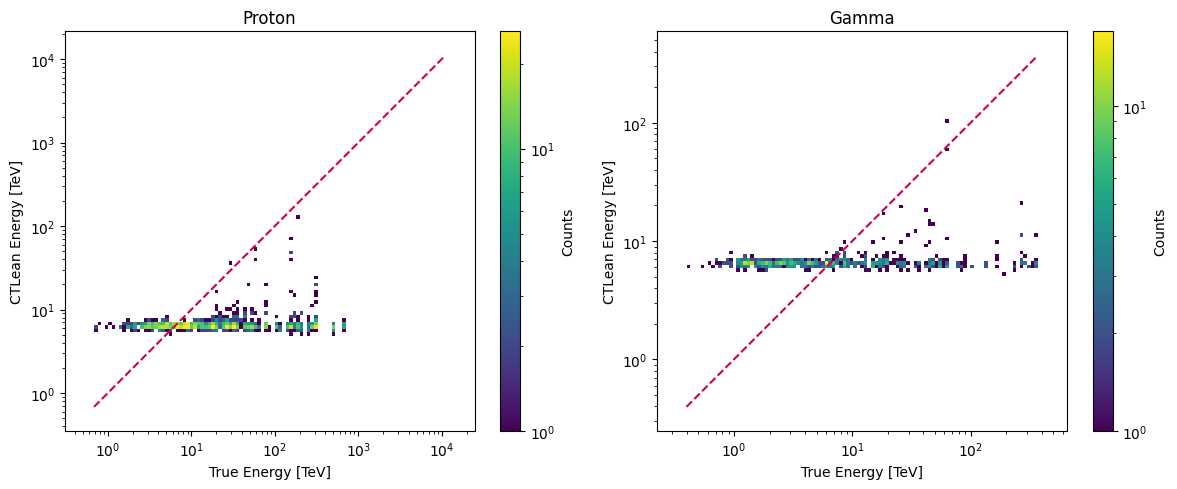

In [28]:
#### MODIFICATION PURPOSE

# Evaluate results for energy regression
if task == "energy":
    mapping_name = {0: "Gamma", 101: "Proton"}
    # Go through each model
    for model in os.listdir(path_models):
        # If parameter defined, only one version per model shown
        versions = sorted(os.listdir(os.path.join(path_models, model)))
        if only_one_version:
            versions = [versions[-1]]
        for version in versions :  
            # Predictions files
            prediction_directory = os.path.join(path_models, model, version, "predict")
            
            # Prepare DataFrame and mapping for classes
            global_predictions_df = pd.DataFrame()
    
            for file in os.listdir(prediction_directory):
                    filename = os.path.join(prediction_directory, file)
                    if filename.endswith(".h5"):
                        with h5py.File(filename, 'r') as data:
                            # Get DL2 predictions
                            if 'dl2/event/subarray/energy/CTLearn' in data:
                                # Predictions
                                pred_ds = data['dl2/event/subarray/energy/CTLearn']['event_id', 'CTLearn_energy', 'CTLearn_is_valid', 'CTLearn_energy_uncert']
                                pred_ds = pd.DataFrame(pred_ds)
                                pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]
                                
                                # Ground Truth
                                ground_truth = data["simulation/event/subarray/shower"][:]
                                ground_truth_df = pd.DataFrame(ground_truth, columns=["event_id", "true_energy", "true_shower_primary_id"])
                                
                                # Combine ground truth with prediction
                                combined_df = pd.merge(pred_ds, ground_truth_df, on="event_id", how="inner")
                                combined_df["particle_name"] = combined_df["true_shower_primary_id"].map(mapping_name)
                                
                                # Merge with others result files
                                global_predictions_df = pd.concat([global_predictions_df, combined_df], ignore_index=True)
                            

            fig, axs = plt.subplots(1, len(global_predictions_df["particle_name"].unique()), figsize=(12, 5))
            for i, particle in enumerate(global_predictions_df["particle_name"].unique()):

                if len(global_predictions_df["particle_name"].unique()) > 1:
                    ax = axs[i]
                else:
                    ax = axs

                # Extract only wanted energies
                particle_df = global_predictions_df[global_predictions_df["particle_name"] == particle]
                
                # Extract only wanted energies
                energy_pred = particle_df["CTLearn_energy"]
                energy_true = particle_df["true_energy"]
                log_pred = np.log10(energy_pred)
                log_true = np.log10(energy_true)
                log_bins = np.logspace(
                    np.log10(
                        min(
                            (
                                min(energy_true),
                                min(energy_pred),
                            )
                        )
                    ),
                    np.log10(
                        max(
                            max(energy_true),
                            max(energy_pred),
                        )
                    ),
                    100,
                    )
                ax.plot(
                    [log_bins[0], log_bins[-1]],
                    [log_bins[0], log_bins[-1]],
                    color="#cf004b",
                    ls="--",
                )
                    
                # Prepare matrix
                ax.hist2d(
                    energy_true,
                    energy_pred,
                    bins=log_bins,
                    cmap="viridis",
                    norm=plt.cm.colors.LogNorm(),
                )

                ax.set_ylabel("CTLean Energy [TeV]")
                ax.set_xlabel("True Energy [TeV]")
                ax.set_xscale("log")
                ax.set_yscale("log")
                ax.set_xlim(log_bins[0], log_bins[-1])
                ax.set_ylim(log_bins[0], log_bins[-1])
                ax.axis("equal")
                ax.set_title(f"{particle}")
                cbar = plt.colorbar(ax.collections[0], ax=ax)
                cbar.set_label("Counts")
    
            plt.tight_layout()
            plt.show()


In [3]:

file = os.path.join("/home/hugo/TM/ml/models/energy/resnet/predict/gamma_200_800E3GeV_20_20deg_ATM52_100505.h5")
with h5py.File(file, "r") as f:
    print("Keys in file:", list(f.keys()))
    structure = True
    if structure: 
        def print_structure(name, obj):
            print(name, "->", type(obj))
        f.visititems(print_structure)
    
    pred_ds = f['dl2/event/subarray/energy/CTLearn']['event_id', 'CTLearn_energy', 'CTLearn_is_valid', 'CTLearn_energy_uncert']
    pred_ds = pd.DataFrame(pred_ds)
    pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]

Keys in file: ['configuration', 'dl1', 'dl2', 'r1', 'simulation']
configuration -> <class 'h5py._hl.group.Group'>
configuration/instrument -> <class 'h5py._hl.group.Group'>
configuration/instrument/subarray -> <class 'h5py._hl.group.Group'>
configuration/instrument/subarray/layout -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope -> <class 'h5py._hl.group.Group'>
configuration/instrument/telescope/camera -> <class 'h5py._hl.group.Group'>
configuration/instrument/telescope/camera/geometry_0 -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope/camera/geometry_1 -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope/camera/readout_0 -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope/camera/readout_1 -> <class 'h5py._hl.dataset.Dataset'>
configuration/instrument/telescope/optics -> <class 'h5py._hl.dataset.Dataset'>
configuration/observation -> <class 'h5py._hl.group.Group'>
configuration/observation/observa

In [6]:
from ctapipe.io import HDF5TableReader

file = os.path.join("/home/hugo/TM/data/samples/gamma/gamma_diffuse_200_300E3GeV_40_40deg_205039.corsika.gz.simtel.h5")

with h5py.File(file, "r") as f:
    if "/configuration" in f:
        print("Attributes in /configuration:")
        for key, val in f["/configuration"].attrs.items():
            print(f"  {key}: {val}")

    if "/configuration/simulation/run" in f:
        print("\nAttributes in /configuration/instrument:")
        for key, val in f["/configuration/instrument/subarray/layout"].attrs.items():
            print(f"  {key}: {val}")

Attributes in /configuration:
  CLASS: b'GROUP'
  FILTERS: 199173
  TITLE: Empty(dtype=dtype('S1'))
  VERSION: b'1.0'

Attributes in /configuration/instrument:
  CLASS: b'TABLE'
  CTAFIELD_10_MAXLEN: 14
  CTAFIELD_10_TRANSFORM: b'string'
  CTAFIELD_1_MAXLEN: 2
  CTAFIELD_1_TRANSFORM: b'string'
  CTAFIELD_2_MAXLEN: 3
  CTAFIELD_2_TRANSFORM: b'string'
  CTAFIELD_3_TRANSFORM: b'quantity'
  CTAFIELD_3_UNIT: b'm'
  CTAFIELD_4_TRANSFORM: b'quantity'
  CTAFIELD_4_UNIT: b'm'
  CTAFIELD_5_TRANSFORM: b'quantity'
  CTAFIELD_5_UNIT: b'm'
  CTAFIELD_6_MAXLEN: 7
  CTAFIELD_6_TRANSFORM: b'string'
  CTAFIELD_7_MAXLEN: 2
  CTAFIELD_7_TRANSFORM: b'string'
  FIELD_0_FILL: 0
  FIELD_0_NAME: b'tel_id'
  FIELD_10_FILL: b''
  FIELD_10_NAME: b'tel_description'
  FIELD_1_FILL: b''
  FIELD_1_NAME: b'name'
  FIELD_2_FILL: b''
  FIELD_2_NAME: b'type'
  FIELD_3_FILL: 0.0
  FIELD_3_NAME: b'pos_x'
  FIELD_4_FILL: 0.0
  FIELD_4_NAME: b'pos_y'
  FIELD_5_FILL: 0.0
  FIELD_5_NAME: b'pos_z'
  FIELD_6_FILL: b''
  FIELD_6_

### Evaluation of combined energy and type models

In [32]:
# Can be True or False
have_cuts = True
# For each new cut, add a new cut details with type, value and sign
cuts = [{"type": "gammaness", "value": 0.4, "sign": ">"}]

FileNotFoundError: [Errno 2] No such file or directory: '/home/hugo/TM/ml/models/type/simple/v4/predict'

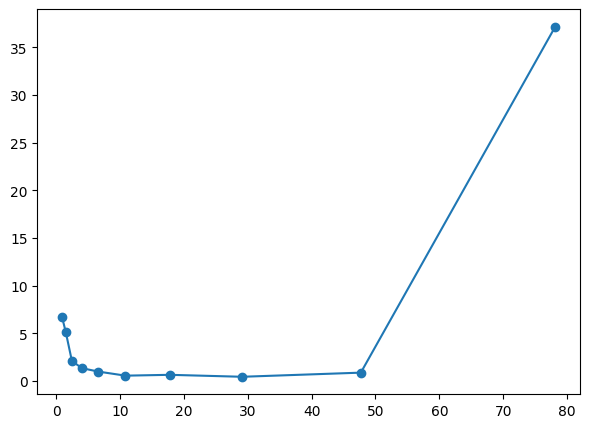

In [33]:
if task == "all":
    plt.figure(figsize=(7, 5))
    mapping_name = {0: "Gamma", 101: "Proton"}
    ops = {
        ">": operator.gt,
        ">=": operator.ge,
        "<": operator.lt,
        "<=": operator.le,
        "==": operator.eq,
        "!=": operator.ne
    }

    # Go through each model
    for model in os.listdir(path_models):
        model_path = os.path.join(path_models, model)
        for version in os.listdir(model_path) :
            
            # Predictions files
            
            type_directory = os.path.join(path_type_models, model, version, "predict")
            energy_directory = os.path.join(path_energy_models, model, version, "predict")
            
            # Prepare DataFrame and mapping for classes
            energy_prediction_df = pd.DataFrame()
    
            for file in os.listdir(energy_directory):
                    filename = os.path.join(energy_directory, file)
                    if filename.endswith(".h5"):
                        with h5py.File(filename, 'r') as data:
                            # Get DL2 predictions
                            if 'dl2/event/subarray/energy/CTLearn' in data:
                                # Predictions
                                pred_ds = data['dl2/event/subarray/energy/CTLearn']['event_id', 'CTLearn_energy', 'CTLearn_is_valid', 'CTLearn_energy_uncert']
                                pred_ds = pd.DataFrame(pred_ds)
                                pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]
                                
                                # Ground Truth
                                ground_truth = data["simulation/event/subarray/shower"][:]
                                ground_truth_df = pd.DataFrame(ground_truth, columns=["event_id", "true_energy", "true_shower_primary_id"])
                                
                                # Combine ground truth with prediction
                                combined_df = pd.merge(pred_ds, ground_truth_df, on="event_id", how="inner")
                                combined_df["particle_name"] = combined_df["true_shower_primary_id"].map(mapping_name)
                                
                                # Merge with others result files
                                energy_prediction_df = pd.concat([energy_prediction_df, combined_df], ignore_index=True)
            
            # Prepare DataFrame and mapping for classes
            type_prediction_df = pd.DataFrame()
                   
            for file in os.listdir(type_directory):
                filename = os.path.join(type_directory, file)
                if filename.endswith(".h5"):
                    with h5py.File(filename, 'r') as data:
                        # Get DL2 predictions
                        if 'dl2/event/subarray/classification/CTLearn' in data:
                            # Predictions
                            pred_ds = data['dl2/event/subarray/classification/CTLearn']['event_id', 'CTLearn_prediction', 'CTLearn_is_valid']
                            pred_ds = pd.DataFrame(pred_ds)
                            
                            # Take only valid events
                            pred_ds = pred_ds[pred_ds["CTLearn_is_valid"] == 1]
                            
                            # Ground truth
                            ground_truth = data["simulation/event/subarray/shower"][:]
                            ground_truth_df = pd.DataFrame(ground_truth, columns=["event_id", "true_shower_primary_id"])
    
                            # Combine ground truth with prediction
                            combined_df = pd.merge(pred_ds, ground_truth_df, on="event_id", how="inner")
                            combined_df["particle_name"] = combined_df["true_shower_primary_id"].map(mapping_name)
    
                            # Merge with others result files
                            type_prediction_df = pd.concat([type_prediction_df, combined_df], ignore_index=True)

            # Merge two predictions data together
            global_predictions_df = pd.merge(energy_prediction_df, type_prediction_df, on="event_id", how="inner")

            # Keep only necessary columns
            global_predictions_df = global_predictions_df[["event_id", "CTLearn_energy", "true_energy", "CTLearn_prediction", "particle_name_x"]]
            global_predictions_df = global_predictions_df.rename(columns={'CTLearn_prediction': "gammaness", 'CTLearn_energy': "energy"})

            # Take a subset corresponding to the cuts wanted
            if have_cuts :
                text_cuts = ""
                for cut in cuts:
                    operation = ops[cut["sign"]]
                    global_predictions_df = global_predictions_df[operation(global_predictions_df[cut["type"]], cut["value"])]
                    text_cuts = text_cuts + f" {cut['type']} {cut['sign']} {cut['value']}"
                    

            # Extract only wanted energies
            energy_pred = global_predictions_df["energy"]
            energy_true = global_predictions_df["true_energy"]    
            
            if len(global_predictions_df) == 0:
                raise ValueError("Cuts too strict ! No more data available !")

            # Build bins (0.1–100 TeV)
            bins = np.logspace(-1, 2, 15)

            # Calculate relative error
            rel_err = (energy_pred - energy_true) / energy_true

            # Assign event to bins
            indices = np.digitize(energy_true, bins)
            results = []

            # For each bin
            for i in range(1, len(bins)):
                # Check if enough data in a bin
                mask = indices == i
                if np.sum(mask) < 20:
                    continue
                # Calculate mean bias (μ) and sigma gauss (σ) / Mean bias is the systematic offset between true and reconstructed energies / Sigma gauss is the standard deviation of relative error distribution
                err_bin = rel_err[mask]
                mu, sigma = norm.fit(err_bin)

                # Representative energy
                represent_energy = np.sqrt(bins[i-1] * bins[i])
                results.append({
                    "represent_energy": represent_energy,
                    "mean_bias": mu,
                    "sigma": sigma
                })

            line_data = pd.DataFrame(results)
            # Add line to graph
            plt.plot(line_data["represent_energy"], line_data["sigma"], "o-", label=f"Energy resolution for {model} - {version}")

    plt.xscale("log")
    plt.xlabel("True Energy [TeV]")
    plt.ylabel("Energy Resolution")
    if have_cuts :
        plt.title(f"Energy Resolution vs True Energy -- Cuts :{text_cuts}")
    else :
        plt.title("Energy Resolution vs True Energy")
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()          

In [ ]:
# angular resolution

